# 02 – Comparativo de LLMs para Detecção em Diagramas

Executa **todos** os modelos (Ollama: qwen2.5vl, llava, deepseek-ocr + Gemini + OpenAI) nas imagens `diagram01.png` e `diagram02.png`. Sem fallback — comparação visual dos bbox para escolher o melhor modelo.

**Ollama:** `make ollama-up` e `make ollama-pull` para subir e baixar modelos.

## 1. Setup e variáveis de ambiente

Carregamos as chaves de API do `.env` e definimos os parâmetros (modelos, temperatura, etc.).

In [1]:
import os
import json
import base64
import re
import hashlib
import asyncio
from pathlib import Path
from dotenv import dotenv_values

for p in [Path("notebooks/.env"), Path(".env"), Path("configs/.env")]:
    if p.exists():
        for k, v in dotenv_values(p).items():
            if v:
                os.environ[k] = v
        break

CONFIG = {
    "google_api_key": os.getenv("GEMINI_API_KEY") or os.getenv("GOOGLE_API_KEY"),
    "openai_api_key": os.getenv("OPENAI_API_KEY"),
    "gemini_model": "gemini-1.5-pro",
    "openai_model": "gpt-4o",
    "ollama_base_url": "http://localhost:11434",
    "ollama_models": ["qwen2.5vl", "llava", "deepseek-ocr"],
    "temperature": 0.0,
}

ASSETS_DIR = Path("assets") if Path("assets").exists() else Path("notebooks/assets")
MODELS_TO_RUN = [f"Ollama/{m}" for m in CONFIG["ollama_models"]] + ["Gemini", "OpenAI"]
print(f"✓ Modelos: {MODELS_TO_RUN}")
print(f"✓ Gemini: {bool(CONFIG['google_api_key'])} | OpenAI: {bool(CONFIG['openai_api_key'])}")

✓ Modelos: ['Ollama/qwen2.5vl', 'Ollama/llava', 'Ollama/deepseek-ocr', 'Gemini', 'OpenAI']
✓ Gemini: True | OpenAI: True


## 2. O prompt do agente de diagrama

O prompt instrui a LLM a retornar um JSON estruturado com componentes, conexões e trust boundaries. É o mesmo usado no backend.

In [2]:
DIAGRAM_PROMPT = """
Analyze this architecture diagram.

1. Identify all components (Users, Servers, Databases, Gateways, Load Balancers, etc.).
2. Identify the connections and data flows between them.
3. Identify trust boundaries (e.g., VPCs, Public/Private subnets, DMZs).

Return ONLY a valid JSON object structured as:
{
  "model": "model_name",
  "components": [{"id": "unique_id", "type": "ComponentType", "name": "Display Name", "bbox": [x_min, y_min, x_max, y_max]}],
  "connections": [{"from": "source_id", "to": "target_id", "protocol": "HTTPS/HTTP/TCP/etc"}],
  "boundaries": ["boundary name 1", "boundary name 2"]
}

Important:
- Each component must have a unique id
- Include bbox for each component: [x_min, y_min, x_max, y_max] as fractions 0.0-1.0 of image dimensions. Origin (0,0) top-left. x=horizontal, y=vertical. Example: top-left quarter = [0, 0, 0.25, 0.25]. Be precise: tight bounding box around each component.
- Use descriptive component types (User, Server, Database, Gateway, LoadBalancer, Cache, Queue, API, Service)
- Include the communication protocol for each connection when visible
"""

print("Prompt (primeiras linhas):")
print(DIAGRAM_PROMPT[:350], "...")

Prompt (primeiras linhas):

Analyze this architecture diagram.

1. Identify all components (Users, Servers, Databases, Gateways, Load Balancers, etc.).
2. Identify the connections and data flows between them.
3. Identify trust boundaries (e.g., VPCs, Public/Private subnets, DMZs).

Return ONLY a valid JSON object structured as:
{
  "model": "model_name",
  "components": [{"i ...


## 3. Parser de JSON da resposta da LLM

A LLM pode retornar texto com markdown (```json ... ```) ou JSON solto. Extraímos o objeto JSON válido.

In [3]:
def parse_json_from_llm(text: str, service_name: str = "LLM") -> dict:
    """Extrai e parseia JSON da resposta da LLM."""
    if not text or not text.strip():
        return {"error": "Empty response", "error_type": "empty", "service": service_name}
    text = text.strip().replace("```json", "").replace("```", "").strip()
    for start, end in [("{", "}"), ("[", "]")]:
        idx = text.find(start)
        if idx != -1:
            depth = 0
            for i, c in enumerate(text[idx:], idx):
                if c == start:
                    depth += 1
                elif c == end:
                    depth -= 1
                    if depth == 0:
                        try:
                            return json.loads(text[idx : i + 1])
                        except json.JSONDecodeError:
                            pass
    match = re.search(r"```(?:json)?\s*([\s\S]*?)```", text)
    if match:
        try:
            return json.loads(match.group(1).strip())
        except json.JSONDecodeError:
            pass
    return {"error": "Invalid JSON response", "error_type": "invalid_json", "service": service_name}

print("✓ Parser de JSON definido")

✓ Parser de JSON definido


## 4. Cache (evitar chamadas repetidas)

Cache em SQLite por (prompt + hash da imagem). Economiza créditos ao reprocessar a mesma imagem.

> ⚠️ **Nota:** Usamos SQLite no notebook para simplicidade. Em produção, o cache final será **Redis**.

In [4]:
import sqlite3

CACHE_DB = Path(".langchain_cache.db")
if not CACHE_DB.exists():
    CACHE_DB = Path("notebooks/.langchain_cache.db")

def _init_db():
    with sqlite3.connect(CACHE_DB) as c:
        c.execute("CREATE TABLE IF NOT EXISTS llm_cache (k TEXT PRIMARY KEY, v TEXT)")

def cache_key(prefix: str, prompt: str, image_bytes: bytes) -> str:
    h = hashlib.sha256(image_bytes).hexdigest()[:16]
    return f"{prefix}_{hashlib.sha256((prompt + h).encode()).hexdigest()[:24]}"

def cache_get(prefix: str, prompt: str, image_bytes: bytes) -> dict | None:
    _init_db()
    key = cache_key(prefix, prompt, image_bytes)
    with sqlite3.connect(CACHE_DB) as c:
        row = c.execute("SELECT v FROM llm_cache WHERE k = ?", (key,)).fetchone()
    return json.loads(row[0]) if row else None

def cache_set(prefix: str, value: dict, prompt: str, image_bytes: bytes) -> None:
    _init_db()
    key = cache_key(prefix, prompt, image_bytes)
    with sqlite3.connect(CACHE_DB) as c:
        c.execute("INSERT OR REPLACE INTO llm_cache (k, v) VALUES (?, ?)", (key, json.dumps(value)))

print(f"✓ Cache SQLite: {CACHE_DB}")

✓ Cache SQLite: .langchain_cache.db


## 5. Invocação por LLM (Gemini, OpenAI, Ollama)

Cada função envia a imagem em base64 + prompt para a API correspondente e retorna o JSON parseado ou um dict com `error`.

In [5]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
try:
    from langchain_ollama import ChatOllama
except ImportError:
    from langchain_community.chat_models import ChatOllama

def _image_mimetype(image_bytes: bytes) -> str:
    if image_bytes[:8] == b"\x89PNG\r\n\x1a\n":
        return "image/png"
    return "image/jpeg"

async def invoke_gemini(prompt: str, image_bytes: bytes) -> dict:
    if not CONFIG["google_api_key"]:
        return {"error": "Gemini not configured", "service": "Gemini"}
    llm = ChatGoogleGenerativeAI(
        model=CONFIG["gemini_model"],
        temperature=CONFIG["temperature"],
        google_api_key=CONFIG["google_api_key"],
    )
    b64 = base64.b64encode(image_bytes).decode("utf-8")
    mime = _image_mimetype(image_bytes)
    msg = HumanMessage(content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:{mime};base64,{b64}"}},
    ])
    try:
        r = await llm.ainvoke([msg])
        return parse_json_from_llm(getattr(r, "content", str(r)), "Gemini")
    except Exception as e:
        return {"error": str(e), "service": "Gemini"}

async def invoke_openai(prompt: str, image_bytes: bytes) -> dict:
    if not CONFIG["openai_api_key"]:
        return {"error": "OpenAI not configured", "service": "OpenAI"}
    llm = ChatOpenAI(
        model=CONFIG["openai_model"],
        temperature=CONFIG["temperature"],
        api_key=CONFIG["openai_api_key"],
    )
    b64 = base64.b64encode(image_bytes).decode("utf-8")
    msg = HumanMessage(content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64}"}},
    ])
    try:
        r = await llm.ainvoke([msg])
        return parse_json_from_llm(getattr(r, "content", str(r)), "OpenAI")
    except Exception as e:
        return {"error": str(e), "service": "OpenAI"}

async def invoke_ollama(prompt: str, image_bytes: bytes, model: str = "qwen2.5vl") -> dict:
    # timeout=180: modelos vision podem demorar (Ollama em Docker)
    llm = ChatOllama(
        model=model,
        base_url=CONFIG["ollama_base_url"],
        client_kwargs={"timeout": 180},
    )
    b64 = base64.b64encode(image_bytes).decode("utf-8")
    mime = _image_mimetype(image_bytes)
    msg = HumanMessage(content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:{mime};base64,{b64}"}},
    ])
    try:
        r = await llm.ainvoke([msg])
        return parse_json_from_llm(getattr(r, "content", str(r)), "Ollama")
    except Exception as e:
        return {"error": str(e), "service": "Ollama"}

print("✓ Funções Gemini, OpenAI e Ollama definidas")

✓ Funções Gemini, OpenAI e Ollama definidas


## 6. Execução de todos os modelos (comparativo)

Executa **todos** os modelos em paralelo, sem fallback. Retorna um dict {modelo: resultado} para comparação.

In [6]:
def is_valid_result(result: dict) -> bool:
    if not isinstance(result, dict) or "error" in result:
        return False
    comps = result.get("components", [])
    return isinstance(comps, list)

async def run_single_model(name: str, image_bytes: bytes) -> tuple[str, dict]:
    if name.startswith("Ollama/"):
        model = name.split("/", 1)[1]
        res = await invoke_ollama(DIAGRAM_PROMPT, image_bytes, model=model)
    elif name == "Gemini":
        cached = cache_get("gemini_diagram", DIAGRAM_PROMPT, image_bytes)
        if cached is not None:
            res = cached
        else:
            res = await invoke_gemini(DIAGRAM_PROMPT, image_bytes)
            if "error" not in res:
                cache_set("gemini_diagram", res, DIAGRAM_PROMPT, image_bytes)
    elif name == "OpenAI":
        cached = cache_get("openai_diagram", DIAGRAM_PROMPT, image_bytes)
        if cached is not None:
            res = cached
        else:
            res = await invoke_openai(DIAGRAM_PROMPT, image_bytes)
            if "error" not in res:
                cache_set("openai_diagram", res, DIAGRAM_PROMPT, image_bytes)
    else:
        res = {"error": f"Unknown model {name}"}
    return (name, res)

async def run_all_models(image_bytes: bytes) -> dict[str, dict]:
    """Executa todos os modelos em paralelo. Retorna {modelo: resultado}."""
    tasks = [run_single_model(m, image_bytes) for m in MODELS_TO_RUN]
    results = await asyncio.gather(*tasks, return_exceptions=True)
    out = {}
    for name, r in zip(MODELS_TO_RUN, results):
        if isinstance(r, Exception):
            out[name] = {"error": str(r)}
        else:
            _, res = r; out[name] = res
    return out

print("✓ Função run_all_models definida")

✓ Função run_all_models definida


## 7. Comparativo visual – diagram01 e diagram02

Executa **todos** os modelos em cada imagem e exibe um grid: 2 linhas (imagens) × 5 colunas (modelos). Cada célula mostra a imagem com bbox do modelo correspondente.

Executando 5 modelos em 2 imagens...


/tmp/ipykernel_2028879/2914735715.py:53: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(


  ✓ diagram01.png: ['Ollama/qwen2.5vl', 'Ollama/llava', 'Ollama/deepseek-ocr', 'Gemini', 'OpenAI']
  ✓ diagram02.png: ['Ollama/qwen2.5vl', 'Ollama/llava', 'Ollama/deepseek-ocr', 'Gemini', 'OpenAI']


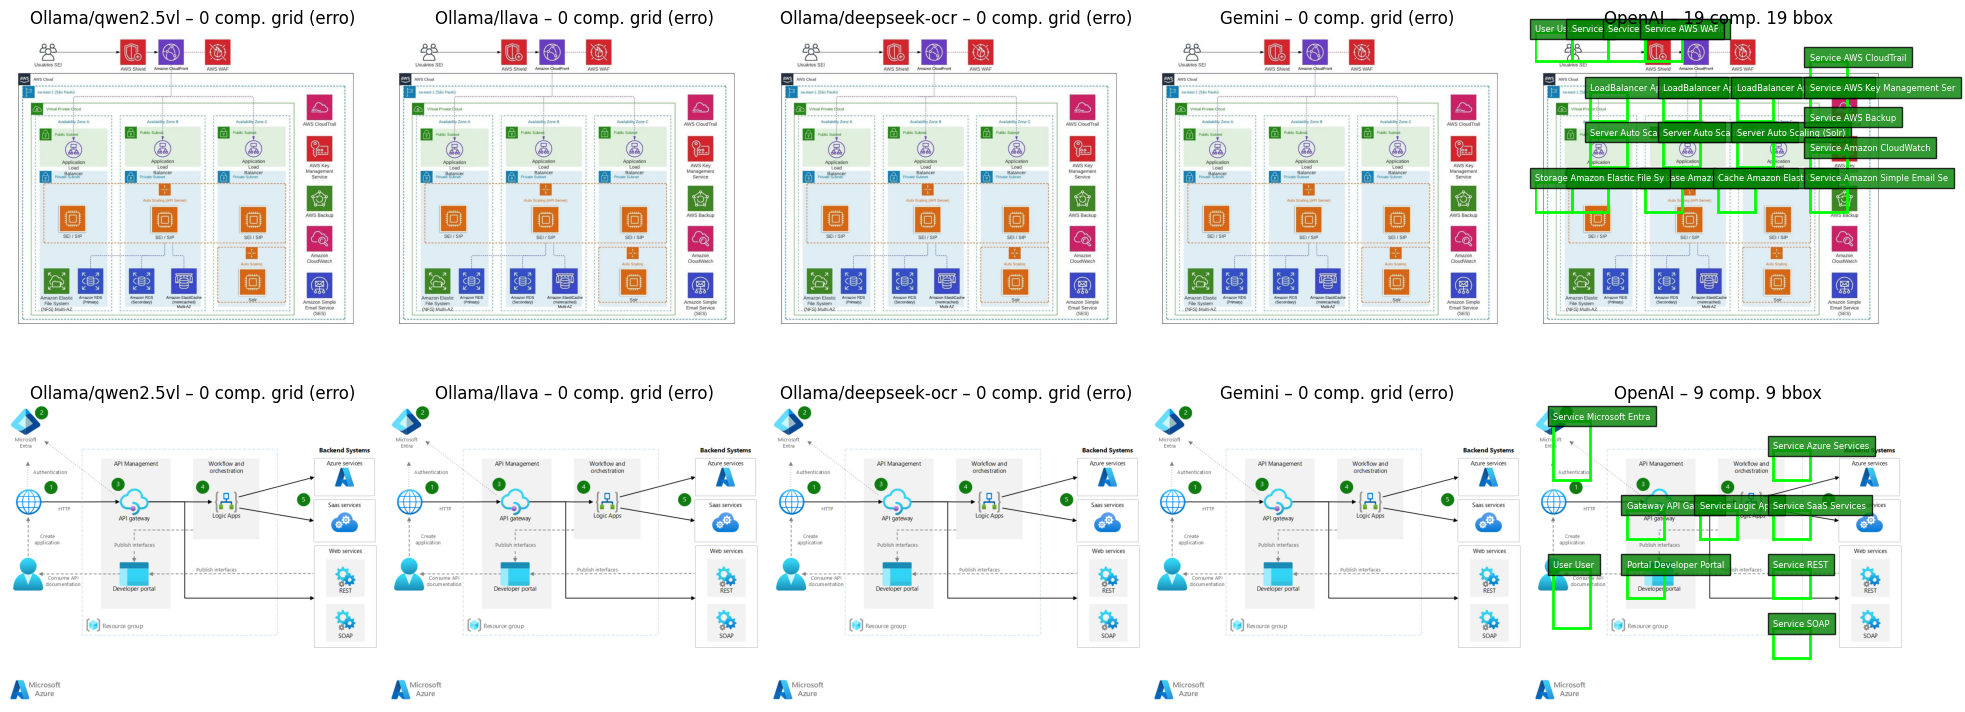

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def _bbox_to_pixels(bbox, w, h):
    """Converte bbox para (x1,y1,x2,y2) em pixels. Precisão: normalizado 0-1, ou % 0-100, ou pixels."""
    if not bbox or len(bbox) < 4:
        return None
    try:
        vals = [float(x) for x in bbox[:4]]
    except (ValueError, TypeError):
        return None
    mx = max(vals)
    if mx <= 1.0 and min(vals) >= 0:
        x1, y1, x2, y2 = vals[0] * w, vals[1] * h, vals[2] * w, vals[3] * h
    elif mx <= 100:
        x1, y1, x2, y2 = vals[0]/100*w, vals[1]/100*h, vals[2]/100*w, vals[3]/100*h
    else:
        x1, y1, x2, y2 = vals[0], vals[1], vals[2], vals[3]
    x1, x2 = max(0, min(x1, x2)), min(w, max(x1, x2))
    y1, y2 = max(0, min(y1, y2)), min(h, max(y1, y2))
    if x2 - x1 < 2 or y2 - y1 < 2:
        return None
    return (int(x1), int(y1), int(x2), int(y2))

def plot_llm_result(img_array, result, title, model_name="", ax=None):
    """Desenha bbox na imagem. ax=None cria figura nova."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img_array)
    h, w = img_array.shape[:2]
    comps = result.get("components", []) if isinstance(result, dict) else []
    n_bbox = 0
    comps_sem_bbox = []
    for c in comps:
        pix = _bbox_to_pixels(c.get("bbox"), w, h)
        if pix:
            x1, y1, x2, y2 = pix
            label = f"{c.get('type', '')} {c.get('name', '')}".strip()[:30]
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="lime", linewidth=2))
            ax.text(x1, max(0, y1 - 5), label, color="white", fontsize=6, bbox=dict(facecolor="green", alpha=0.8))
            n_bbox += 1
        else:
            comps_sem_bbox.append(c)
    if comps_sem_bbox:
        ncol = min(4, len(comps_sem_bbox))
        nrow = max(1, (len(comps_sem_bbox) + ncol - 1) // ncol)
        pad = 20
        cell_w = max(60, (w - 2 * pad) // ncol)
        cell_h = max(40, (h - 2 * pad) // nrow)
        for i, c in enumerate(comps_sem_bbox):
            col, row = i % ncol, i // ncol
            x1 = pad + col * cell_w + 5
            y1 = pad + row * cell_h + 5
            x2 = x1 + cell_w - 10
            y2 = y1 + cell_h - 10
            label = f"{c.get('type', '')} {c.get('name', '')}".strip()[:25]
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="lime", linewidth=2))
            ax.text(x1, max(0, y1 - 5), label, color="white", fontsize=6, bbox=dict(facecolor="green", alpha=0.8))
    ax.axis("off")
    err = " (erro)" if result.get("error") else ""
    sub = f"{n_bbox} bbox" if n_bbox else "grid"
    ax.set_title(f"{model_name} – {len(comps)} comp. {sub}{err}")
    if ax is None:
        plt.tight_layout()
        plt.show()

test_images = ["diagram01.png", "diagram02.png"]
print(f"Executando {len(MODELS_TO_RUN)} modelos em {len(test_images)} imagens...")
all_results = {}
for name in test_images:
    path = ASSETS_DIR / name
    if not path.exists():
        print(f"❌ {name} não encontrado")
        continue
    image_bytes = path.read_bytes()
    all_results[name] = await run_all_models(image_bytes)
    ok = [m for m, r in all_results[name].items() if not r.get("error")]
    err = [(m, r.get("error", "")[:60]) for m, r in all_results[name].items() if r.get("error")]
    print(f"  ✓ {name}: {len(ok)} OK, {len(err)} erro(s)")
    for m, e in err:
        print(f"      ⚠ {m}: {e}...")

nrows, ncols = len(test_images), len(MODELS_TO_RUN)
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
if nrows == 1:
    axes = [axes]
for row, img_name in enumerate(test_images):
    path = ASSETS_DIR / img_name
    if not path.exists():
        continue
    img_arr = np.array(Image.open(path).convert("RGB"))
    res = all_results.get(img_name, {})
    for col, model_name in enumerate(MODELS_TO_RUN):
        ax = axes[row][col]
        plot_llm_result(img_arr, res.get(model_name, {}), img_name, model_name, ax=ax)
plt.tight_layout()
plt.show()